In [1]:
import math
import os
import re
import shutil
import sys
import warnings

import chardet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statistics import median

from constants import bins_axis_names, bin_dimensions_regex, boat_speed_feature, \
                    boxplot_axis_name, coc_feature_name, feature_regex, identifier_features, \
                    fiber_optics_structure_features, fiber_optics_appendix_features, \
                    other_sensor_features, statistics_features, wind_features

In [2]:
# Bins to analyse.
bin_keys = ['bin_x{}to{}_y{}to{}'.format(x_min, x_max, y_min, y_max) for x_min, x_max, y_min, y_max in [(-95, -90, 8, 10),
                                                                                                        (-145, -140, 22, 24),
                                                                                                        (50, 55, 16, 18)]]

def read_csv(fnames):
    """Read CSV file(s) to a Pandas Dataframe"""
    def detect_and_read(fname):
        with open(fname, 'rb') as f:
            return pd.read_csv(fname, sep=';', encoding=chardet.detect(f.read())['encoding'])
    return pd.concat(map(lambda fname: detect_and_read(fname), fnames), sort=False)

def preprocess_data(df,
                identifier_cols=identifier_features,
                cols_to_preprocess=fiber_optics_structure_features + fiber_optics_appendix_features,
                other_cols=other_sensor_features + wind_features + [boat_speed_feature],
                regex=feature_regex):
    """Preprocess the dataset"""
    preprocessed_df = pd.DataFrame()
    for old_col, new_col in identifier_cols + cols_to_preprocess + other_cols:
        if (old_col, new_col) not in identifier_cols + other_cols:
            preprocessed_df[new_col] = df.filter(regex=(regex.format(old_col))).mean(axis=1)
        else:
            preprocessed_df[new_col] = df[old_col]
    return preprocessed_df

def sort_corr(corr, num_features):
    """Sort correlation dictionary"""
    sorted_corr = sorted(corr.items(), key=lambda x: abs(x[1]), reverse=True)[:num_features]
    return sorted(sorted_corr, key=lambda x: x[1], reverse=True)

def compute_sorted_corr(df, target_feature=boat_speed_feature[1], num_features=50):
    """Compute sorted correlated features with the target feature"""
    corr = {}
    for col in df.columns:
        if col != target_feature:
            f_corr = df[target_feature].corr(df[col])
            if not math.isnan(f_corr):
                corr[col] = f_corr
    cols = [target_feature] + [x[0] for x in sort_corr(corr, num_features)]
    if len(cols) <= 1:
        return None, None
    return df[cols].corr(), corr

def create_PCA(df,
            target_feature=boat_speed_feature[1],
            var_thresh=.75,
            column_name='PC_{}',
            exclude=[x[1] for x in identifier_features + wind_features]):
    """Create Principal Component Analysis"""
    df = df.drop(exclude, axis=1)
    df.dropna(axis=1, how='all', inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(df.mean(), inplace=True)
    X, y = StandardScaler().fit_transform(df.drop(target_feature, axis=1).reset_index()), df[target_feature].reset_index()
    pca = PCA(var_thresh)
    principal_components = pca.fit_transform(X)
    return pca, pd.concat([pd.DataFrame(data=principal_components, columns=[column_name.format(i+1) for i in range(0, len(principal_components[0]))]), y], axis=1).drop(['index'], axis=1)

def create_bins(df,
                wind_features=[x[1] for x in wind_features],
                target_feature=boat_speed_feature[1],
                statistics_cols=statistics_features,
                dx=5, dy=2, min_thresh=5,
                exclude=[x[1] for x in identifier_features + wind_features],
                target_bins=bin_keys):
    """Create bins"""
    bins = {}
    for max_x in range(-180, 180, dx):
        for max_y in range(0, math.ceil(df[wind_features[1]].max()), dy):
            binned_df = df.query('{0} >= {2} and {0} < {2}+{4} and {1} >= {3} and {1} < {3}+{5}'.format(wind_features[0], wind_features[1],
                                                                                                        max_x, max_y,
                                                                                                        dx, dy))
            bin_name = 'bin_x{}to{}_y{}to{}'.format(max_x, max_x+dx, max_y, max_y+dy)
            if bin_name in target_bins:
                bin_size = len(binned_df.index)
                bin_corr, unsorted_corr = compute_sorted_corr(binned_df.drop(exclude, axis=1))
                if bin_size >= min_thresh and bin_corr is not None:
                    pca, pca_df = create_PCA(binned_df)
                    bins[bin_name] = {'bin': binned_df,
                                    'size': bin_size,
                                    'corr': bin_corr,
                                    'corr_list': pd.DataFrame(data=sort_corr(unsorted_corr, num_features=50), columns=statistics_cols),
                                    'pca': pca,
                                    'pca_df': pca_df}
    return bins, dx, dy, max_x, max_y

def plot_wind_angle_speed(df, x_start, y_start, x_finish, y_finish, dx, dy, markersize, wind_features=[x[1] for x in wind_features], axis_names=bins_axis_names, main=False):
    """Plot the wind angle-speed space"""
    _, ax = plt.subplots()
    ax.set_xlabel(axis_names[0])
    ax.set_ylabel(axis_names[1])
    ax.plot(df[wind_features[0]].tolist(), df[wind_features[1]].tolist(), 'ko', markersize=markersize)
    if main:
        ax.set_xticks(np.arange(x_start, x_finish, dx*6))
        ax.set_xticks(np.arange(x_start, x_finish, dx), minor=True)
        ax.set_yticks(np.arange(y_start, y_finish, dy))
        ax.grid(which='both', lw=.75)
    else:
        ax.set_xlim(x_start, x_finish)
        ax.set_ylim(y_start, y_finish)
        ax.grid(lw=.75)
    plt.tight_layout()
    plt.show()
    plt.clf()

def plot_boxplot(df, target_feature=boat_speed_feature[1], axis_name=boxplot_axis_name):
    """Plot the boxplot for boat speed"""
    ax = df.boxplot(column=target_feature, showfliers=df[target_feature].median() == df[target_feature].mode().iloc[0], return_type='axes')
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.set_ylabel(axis_name)
    plt.tight_layout()
    plt.show()
    plt.clf()

def plot_corr(corr):
    """Plot the correlations with boat speed"""
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, lw=.75)
    plt.xticks(rotation=30, ha='right', fontsize=5)
    plt.yticks(fontsize=5)
    plt.tight_layout()
    plt.show()
    plt.clf()

def plot_circle_of_correlations(pc_infos,
                            ebouli,
                            pairs,
                            columns,
                            feature_name=coc_feature_name):
    """Plot the circle of correlation"""
    (pc_1, pc_2) = pairs
    pc_infos[feature_name] = columns[:len(pc_infos.index)]
    pc_infos.sort_values(by=['PC_{}'.format(pc_1)], ascending=False, inplace=True)
    plt.Circle((0,0), radius=10, color='g', fill=False)
    circle1 = plt.Circle((0, 0), radius=1, color='g', fill=False)
    fig = plt.gcf()
    fig.gca().add_artist(circle1)
    for idx in range(len(pc_infos['PC_{}'.format(pc_1)])):
        x = pc_infos['PC_{}'.format(pc_1)][idx]
        y = pc_infos['PC_{}'.format(pc_2)][idx]
        plt.plot([0.0, x], [0.0, y], 'k-')
        plt.plot(x, y, 'rx')
        plt.annotate(pc_infos.index[idx], xy=(x, y), fontsize=7.5)
    plt.xlabel('{} ({}%%)'.format('PC_{}'.format(pc_1), str(ebouli[0])[:4].lstrip('0.')))
    plt.ylabel('{} ({}%%)'.format('PC_{}'.format(pc_2), str(ebouli[1])[:4].lstrip('0.')))
    plt.xlim((-1, 1))
    plt.ylim((-1, 1))
    plt.tight_layout()
    plt.show()
    return pd.DataFrame(data={'Label': [label+1 for label in range(len(pc_infos.index))],
                    'Feature': [feature for feature in pc_infos[feature_name].values[:len(pc_infos.index)]]})

In [3]:
# Ignore RunTimeWarning.
warnings.filterwarnings('ignore')

# Ignore PyPlot warning.
plt.rcParams.update({'figure.max_open_warning': 0})

# Version number.
version = 'v2'

In [4]:
# Read from CSV file(s).
df = read_csv(map(lambda fname: './data/{}/{}.csv'.format(version, fname), ['data-part-1', 'data-part-2']))

# Preprocess the dataset.
df = preprocess_data(df)

# Create the bins. Default size: 5˚ by 2 knots.
bins, dx, dy, _, max_y = create_bins(df)

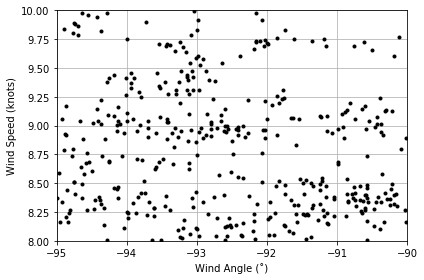

<Figure size 432x288 with 0 Axes>

In [5]:
# Retrieve another example of a bin. (-95 to -90˚, 8 to 10 knots)
bin_name = 'bin_x-95to-90_y8to10'
binned_df, bin_corr, bin_corr_list, bin_pca, bin_pca_df = bins[bin_name]['bin'], bins[bin_name]['corr'], bins[bin_name]['corr_list'], bins[bin_name]['pca'], bins[bin_name]['pca_df']
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(bin_dimensions_regex, bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish, y_finish, dx, dy, 3)

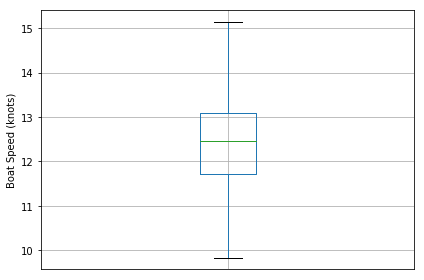

<Figure size 432x288 with 0 Axes>

In [6]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df)

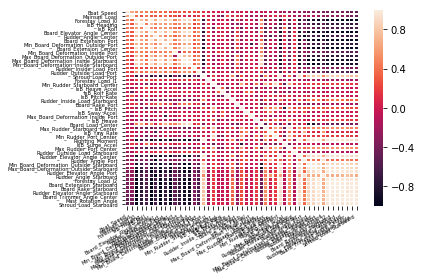

<Figure size 432x288 with 0 Axes>

In [7]:
# Plot the correlation heatmap with boat speed.
plot_corr(bin_corr)

In [8]:
# Show to top correlated features.
bin_corr_list

,Feature,Corr
0,Mainsail_Load,0.654274
1,Forestay_Load_J0,0.496085
2,IxB_Heading,0.480579
3,IxB_Roll,0.450215
4,Board_Elevator_Angle_Center,0.391327
5,Rudder_Angle_Center,0.371162
6,Board_Extension_Port,0.370662
7,Min_Board_Deformation_Outside_Port,0.336391
8,Board_Extension_Center,0.280629
9,Min_Board_Deformation_Inside_Port,0.275055


In [9]:
# Show bin's PCA.
bin_pca_df

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,Boat_Speed
0,0.390251,4.015859,18.402867,0.515052,-9.146972,15.172375,7.99396
1,-4.546520,4.825349,0.658120,-2.372379,0.769448,0.323066,12.97392
2,-4.191140,4.212641,-0.838043,0.996023,-0.816116,0.269894,12.92082
3,-3.605526,-0.430149,-0.716730,1.496527,-1.642400,-0.277558,12.85933
4,-2.794966,-2.516202,-0.499703,-0.737148,-0.164916,0.233754,12.79903
5,-2.500028,-2.038465,-0.913742,-1.000954,1.661899,2.285962,12.79856
6,-2.709383,-3.418057,0.205314,1.772670,0.241846,1.532538,12.88838
7,-2.435854,-6.569322,1.001896,-0.778369,-0.997238,-0.439452,13.01570
8,-3.089131,-2.821088,1.576908,-1.810785,-0.116172,-0.395455,13.15232
9,-3.610292,-0.746511,1.143267,-1.517515,-1.151592,-0.796824,13.27922


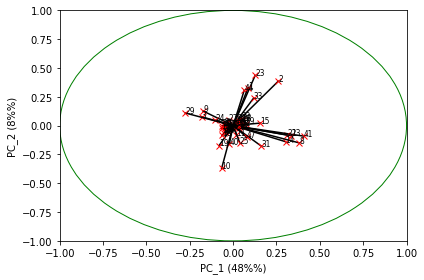

,Label,Feature
0,1,Max_Front_Beam_Lower_Forward_Rake_Starboard
1,2,Max_Front_Beam_Upper_Aft_Rake_Starboard
2,3,Max_Hull_To_Center
3,4,Max_Front_Beam_Upper_Aft_Rake_Port
4,5,Max_Front_Beam_Upper_Forward_Rake_Port
5,6,Max_Hull_Temp_To_Port
6,7,Max_Hull_Temp_Center
7,8,Min_Front_Beam_Lower_Forward_Rake_Starboard
8,9,Min_Front_Beam_Lower_Forward_Rake_Port
9,10,Max_Hull_Temp_Port


In [10]:
# Show the circle or correlations.
ebouli = pd.Series(bin_pca.explained_variance_ratio_)
plot_circle_of_correlations(pd.DataFrame(np.transpose(bin_pca.components_),
                                        columns=['PC_{}'.format(i) for i in range(len(ebouli))]),
                            ebouli,
                            (1, 2),
                            binned_df.drop([x[1] for x in identifier_features + wind_features], axis=1).columns.values)

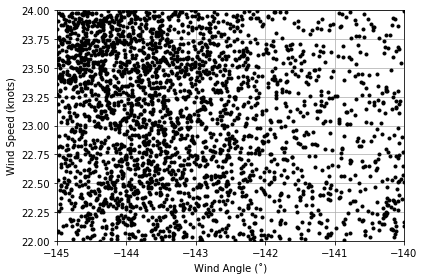

<Figure size 432x288 with 0 Axes>

In [11]:
# Retrieve another example of a bin. (-145 to -140˚, 22 to 24 knots)
bin_name = 'bin_x-145to-140_y22to24'
binned_df, bin_corr, bin_corr_list, bin_pca, bin_pca_df = bins[bin_name]['bin'], bins[bin_name]['corr'], bins[bin_name]['corr_list'], bins[bin_name]['pca'], bins[bin_name]['pca_df']
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(bin_dimensions_regex, bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish, y_finish, dx, dy, 3)

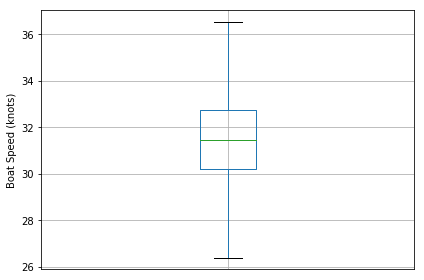

<Figure size 432x288 with 0 Axes>

In [12]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df)

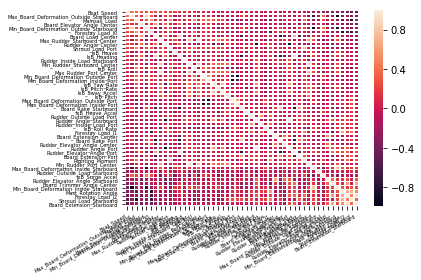

<Figure size 432x288 with 0 Axes>

In [13]:
# Plot the correlation heatmap with boat speed.
plot_corr(bin_corr)

In [14]:
# Show to top correlated features.
bin_corr_list

,Feature,Corr
0,Max_Board_Deformation_Outside_Starboard,0.436943
1,Mainsail_Load,0.327353
2,Board_Elevator_Angle_Center,0.301821
3,Min_Board_Deformation_Outside_Starboard,0.261948
4,Forestay_Load_J0,0.256556
5,Board_Load_Center,0.248147
6,Max_Rudder_Starboard_Center,0.244394
7,Rudder_Angle_Center,0.210159
8,Shroud_Load_Port,0.195455
9,IxB_Heave,0.195114


In [15]:
# Show bin's PCA.
bin_pca_df

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,Boat_Speed
0,8.144621,24.719478,-4.000568,28.930346,-1.521587,19.831670,-2.814463,0.653440,6.411131,-8.795781,1.475013,20.75577
1,11.445115,13.930632,1.265678,13.077360,3.638885,-7.786408,1.672821,-10.323634,-1.450651,0.091941,1.794898,16.31040
2,11.226726,14.534403,0.580173,13.457658,3.925299,-7.523693,0.110203,-10.483955,-0.550322,0.112207,2.325438,16.02005
3,10.581322,14.326300,-0.315527,14.157870,3.439896,-6.661113,0.513054,-10.410083,-1.180319,-0.255678,1.753406,15.69126
4,10.849708,15.334820,-0.183193,14.562811,2.867738,-6.536940,0.473268,-9.206501,-0.896440,-0.534859,1.571529,15.48456
5,10.892746,15.294028,0.105355,14.908536,2.865624,-6.550669,0.994542,-9.176662,-1.011131,-0.383316,1.552295,15.36175
6,10.550841,14.712889,0.659612,15.891211,2.592250,-6.262776,0.853974,-9.044468,-0.820467,-0.307956,1.442313,15.30420
7,10.303401,15.223049,-0.370517,15.715989,2.427551,-5.508089,0.765613,-8.836422,-1.009195,-0.781508,1.445018,15.34757
8,9.908843,14.953821,-0.716669,15.906644,2.661755,-5.415125,-0.590846,-9.057781,-0.411528,-0.449160,2.170803,15.47296
9,10.997155,14.296323,1.661829,14.424648,3.117749,-6.155068,1.448689,-10.337417,-0.362634,0.596817,-0.294311,15.32853


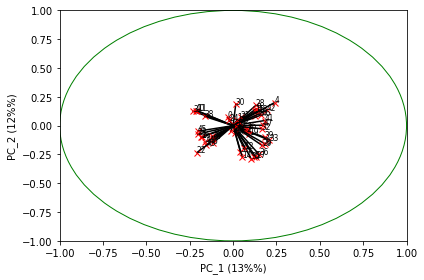

,Label,Feature
0,1,Min_Front_Beam_Upper_Forward_Rake_Starboard
1,2,Max_Front_Beam_To_Starboard
2,3,Max_Hull_Temp_Starboard
3,4,Min_Front_Beam_Lower_Forward_Rake_Port
4,5,Max_Front_Beam_Lower_Aft_Rake_Port
5,6,Max_Hull_Upper_Starboard_Port
6,7,Min_Front_Beam_Temp_Port
7,8,Min_Front_Beam_Temp_To_Starboard
8,9,Min_Front_Beam_To_Starboard
9,10,Max_Hull_Upper_Port_Starboard


In [16]:
# Show the circle or correlations.
ebouli = pd.Series(bin_pca.explained_variance_ratio_)
plot_circle_of_correlations(pd.DataFrame(np.transpose(bin_pca.components_),
                                        columns=['PC_{}'.format(i) for i in range(len(ebouli))]),
                            ebouli,
                            (1, 2),
                            binned_df.drop([x[1] for x in identifier_features + wind_features], axis=1).columns.values)

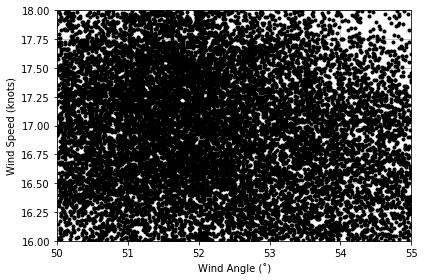

<Figure size 432x288 with 0 Axes>

In [17]:
# Retrieve another example of a bin. (50 to 5˚, 16 to 18 knots)
bin_name = 'bin_x50to55_y16to18'
binned_df, bin_corr, bin_corr_list, bin_pca = bins[bin_name]['bin'], bins[bin_name]['corr'], bins[bin_name]['corr_list'], bins[bin_name]['pca']
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(bin_dimensions_regex, bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish, y_finish, dx, dy, 3)

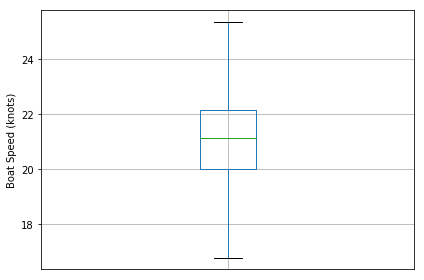

<Figure size 432x288 with 0 Axes>

In [18]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df)

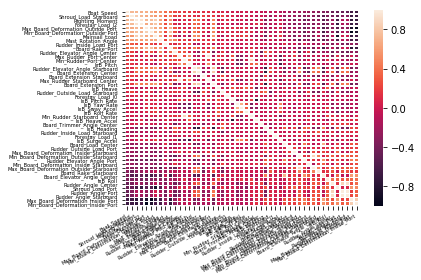

<Figure size 432x288 with 0 Axes>

In [19]:
# Plot the correlation heatmap with boat speed.
plot_corr(bin_corr)

In [20]:
# Show to top correlated features.
bin_corr_list

,Feature,Corr
0,Shroud_Load_Starboard,0.726790
1,Righting_Moment,0.717383
2,Forestay_Load_J2,0.683873
3,Max_Board_Deformation_Outside_Port,0.676110
4,Min_Board_Deformation_Outside_Port,0.645082
5,Mainsail_Load,0.551525
6,Mast_Rotation_Angle,0.534595
7,Rudder_Inside_Load_Port,0.382760
8,Board_Rake_Port,0.328812
9,Rudder_Elevator_Angle_Center,0.222738


In [21]:
# Show bin's PCA.
bin_pca_df

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,Boat_Speed
0,8.144621,24.719478,-4.000568,28.930346,-1.521587,19.831670,-2.814463,0.653440,6.411131,-8.795781,1.475013,20.75577
1,11.445115,13.930632,1.265678,13.077360,3.638885,-7.786408,1.672821,-10.323634,-1.450651,0.091941,1.794898,16.31040
2,11.226726,14.534403,0.580173,13.457658,3.925299,-7.523693,0.110203,-10.483955,-0.550322,0.112207,2.325438,16.02005
3,10.581322,14.326300,-0.315527,14.157870,3.439896,-6.661113,0.513054,-10.410083,-1.180319,-0.255678,1.753406,15.69126
4,10.849708,15.334820,-0.183193,14.562811,2.867738,-6.536940,0.473268,-9.206501,-0.896440,-0.534859,1.571529,15.48456
5,10.892746,15.294028,0.105355,14.908536,2.865624,-6.550669,0.994542,-9.176662,-1.011131,-0.383316,1.552295,15.36175
6,10.550841,14.712889,0.659612,15.891211,2.592250,-6.262776,0.853974,-9.044468,-0.820467,-0.307956,1.442313,15.30420
7,10.303401,15.223049,-0.370517,15.715989,2.427551,-5.508089,0.765613,-8.836422,-1.009195,-0.781508,1.445018,15.34757
8,9.908843,14.953821,-0.716669,15.906644,2.661755,-5.415125,-0.590846,-9.057781,-0.411528,-0.449160,2.170803,15.47296
9,10.997155,14.296323,1.661829,14.424648,3.117749,-6.155068,1.448689,-10.337417,-0.362634,0.596817,-0.294311,15.32853


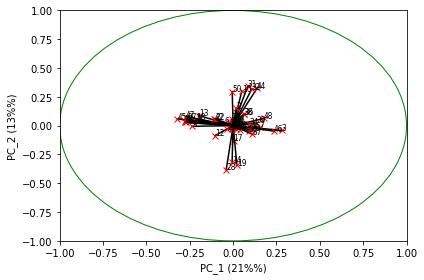

,Label,Feature
0,1,Max_Front_Beam_Upper_Forward_Rake_Starboard
1,2,Min_Hull_Temp_Center
2,3,Min_Front_Beam_Upper_Forward_Rake_Port
3,4,Min_Front_Beam_Lower_Aft_Rake_Port
4,5,Max_Front_Beam_Upper_Aft_Rake_Port
5,6,Min_Front_Beam_To_Starboard
6,7,Max_Hull_Lower_Starboard_Starboard
7,8,Max_Front_Beam_Upper_Forward_Rake_Port
8,9,Min_Front_Beam_Temp_Port
9,10,Min_Hull_To_Center


In [22]:
# Show the circle or correlations.
ebouli = pd.Series(bin_pca.explained_variance_ratio_)
plot_circle_of_correlations(pd.DataFrame(np.transpose(bin_pca.components_),
                                        columns=['PC_{}'.format(i) for i in range(len(ebouli))]),
                            ebouli,
                            (1, 2),
                            binned_df.drop([x[1] for x in identifier_features + wind_features], axis=1).columns.values)